# Geoprocessing Toolkit 2

In [1]:
import os
import pandas as pd
import geopandas as gpd
%matplotlib notebook
from shapely.geometry import Point, LineString, Polygon
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Everything above here should basically be standard at this point!!!

![duh](https://media.giphy.com/media/aVtdz7iNVPI1W/giphy.gif)
________________________________________

Aite lets change the directory!

In [3]:
os.chdir('data/colombia/')

Time to read the shapefile!! __geopandas is our library and then .read_file() is our function__

![duh](https://media.giphy.com/media/y4E6VumnBbIfm/giphy.gif)


In [4]:
colo_shape = gpd.read_file('gadm36_COL_1.shp')

Wanna check it out? Use .plot() or .head()

<IPython.core.display.Javascript object>


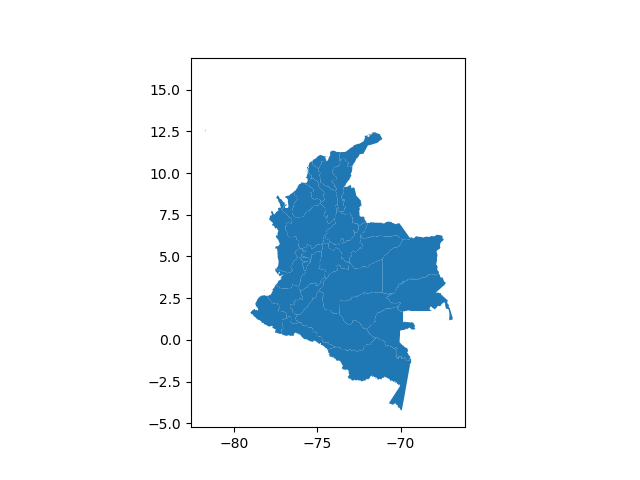

In [5]:
colo_shape.plot()

How about some tabular data? Go to 
* http://geo.aiddata.org/query/#!/
* Select Colombia GADM
* Adm 1 boundary
* Add to Request
    1. VIIRS Nighttime Lights - 2013 SUM
    2. Drug Cultivation Sites
    3. UCDP - 2014 SUM

And lets rename that long csv file. How about colo.csv. Don't forget to put it into the colombia folder!

In [6]:
colo_tab = pd.read_csv('colo.csv')

Who needed encoding? Remeber what it was? 

Hint: y tu brutus?

Wanna check out this data? How about .describe(), dtypes, head/tail() 

In [7]:
colo_tab.describe()

,asdf_id,v4composites_calibrated_201709.2013.sum,drugdata_categorical_201708.none.categorical_count,drugdata_categorical_201708.none.categorical_none,drugdata_categorical_201708.none.categorical_cannabis,drugdata_categorical_201708.none.categorical_coca_bush,drugdata_categorical_201708.none.categorical_opium,drugdata_categorical_201708.none.categorical_mix,ucdp_deaths_171.2014.sum,CCN_1,Shape_Area,ID_0,CCA_1,ID_1,Shape_Length,NL_NAME_1
count,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,29.000000,0.0,32.000000,32.0,0.0,32.000000,32.000000,0.0
mean,15.500000,45950.754482,28964.187500,20697.812500,182.40625,5719.718750,2287.875000,76.375000,5.186207,NaN,2.896519,53.0,NaN,16.500000,11.402621,NaN
std,9.380832,44597.471094,23312.186682,20817.793702,1031.84557,9527.706187,4483.973625,289.216823,7.921387,NaN,2.331093,0.0,NaN,9.380832,5.608735,NaN
min,0.000000,359.000000,46.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.004362,53.0,NaN,1.000000,0.846961,NaN
25%,7.750000,10719.302002,17691.500000,6633.500000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,1.768622,53.0,NaN,8.750000,8.211024,NaN
50%,15.500000,41485.439453,20195.000000,12500.000000,0.00000,511.000000,0.000000,0.000000,0.000000,NaN,2.019395,53.0,NaN,16.500000,10.716741,NaN
75%,23.250000,60246.604492,38531.000000,31748.000000,0.00000,8664.750000,1565.000000,0.000000,7.000000,NaN,3.852642,53.0,NaN,24.250000,15.208211,NaN
max,31.000000,180695.156250,87353.000000,87353.000000,5837.00000,41137.000000,14773.000000,1578.000000,28.000000,NaN,8.734401,53.0,NaN,32.000000,23.775040,NaN


These variable names are terrible! Lets change them real quick.

First we will get a list of column names.

In [8]:
colo_tab.columns

Index(['asdf_id', 'v4composites_calibrated_201709.2013.sum',
       'drugdata_categorical_201708.none.categorical_count',
       'drugdata_categorical_201708.none.categorical_none',
       'drugdata_categorical_201708.none.categorical_cannabis',
       'drugdata_categorical_201708.none.categorical_coca_bush',
       'drugdata_categorical_201708.none.categorical_opium',
       'drugdata_categorical_201708.none.categorical_mix',
       'ucdp_deaths_171.2014.sum', 'CCN_1', 'NAME_0', 'Shape_Area',
       'VARNAME_1', 'ENGTYPE_1', 'NAME_1', 'ID_0', 'HASC_1', 'CCA_1', 'ID_1',
       'TYPE_1', 'Shape_Length', 'NL_NAME_1', 'ISO'],
      dtype='object')

So its not every one that we need to change, just the ones that are long and we plan to use for some analysis.

In [9]:
colo_tab.rename(columns = {'v4composites_calibrated_201709.2013.sum': 'lights',
       'drugdata_categorical_201708.none.categorical_count': 'drug_count',
       'drugdata_categorical_201708.none.categorical_none': 'drug_other',
       'drugdata_categorical_201708.none.categorical_cannabis': 'herb',
       'drugdata_categorical_201708.none.categorical_coca_bush': 'coke',
       'drugdata_categorical_201708.none.categorical_opium': 'heroin',
       'drugdata_categorical_201708.none.categorical_mix': 'drug_mix',
       'ucdp_deaths_171.2014.sum': 'ucdp_deaths'}, inplace = True)

Pretty easy right?!?!?

![chill](https://media.giphy.com/media/TlK63Euc9KArc2a0kEw/giphy.gif)

Lets merge the two!

What column matches up between the shapefile and the tabular file?

In [10]:
colo_tab.head()

,asdf_id,lights,drug_count,drug_other,herb,coke,heroin,drug_mix,ucdp_deaths,CCN_1,NAME_0,Shape_Area,VARNAME_1,ENGTYPE_1,NAME_1,ID_0,HASC_1,CCA_1,ID_1,TYPE_1,Shape_Length,NL_NAME_1,ISO
0,0,1013.670061,87353,87353,0,0,0,0,2.0,NaN,Colombia,8.734401,NaN,Commissiary,Amazonas,53,CO.AM,NaN,1,Comisaría,23.775040,NaN,COL
1,1,151073.993896,51678,43210,0,8465,3,0,17.0,NaN,Colombia,5.168365,NaN,Department,Antioquia,53,CO.AN,NaN,2,Departamento,19.141026,NaN,COL
2,2,11489.069336,20725,9290,0,11435,0,0,28.0,NaN,Colombia,2.071644,NaN,Intendancy,Arauca,53,CO.AR,NaN,3,Intendencia,7.906898,NaN,COL
3,3,54602.371094,3647,3647,0,0,0,0,0.0,NaN,Colombia,0.364899,NaN,Department,Atlántico,53,CO.AT,NaN,4,Departamento,3.285024,NaN,COL
4,4,52571.370117,21386,8088,0,13298,0,0,0.0,NaN,Colombia,2.139413,NaN,Department,Bolívar,53,CO.BL,NaN,5,Departamento,13.922045,NaN,COL


In [11]:
colo_shape.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,COL,Colombia,COL.1_1,Amazonas,None,None,Comisaría,Commissiary,None,CO.AM,"MULTIPOLYGON (((-69.43138 -1.07847, -69.42712 ..."
1,COL,Colombia,COL.2_1,Antioquia,None,None,Departamento,Department,None,CO.AN,"MULTIPOLYGON (((-76.99986 8.99986, -77.00014 8..."
2,COL,Colombia,COL.3_1,Arauca,None,None,Intendencia,Intendancy,None,CO.AR,"POLYGON ((-69.92316 6.05792, -69.92910 6.06720..."
3,COL,Colombia,COL.4_1,Atlántico,None,None,Departamento,Department,None,CO.AT,"POLYGON ((-74.88160 10.34100, -74.88670 10.329..."
4,COL,Colombia,COL.5_1,Bolívar,None,None,Departamento,Department,None,CO.BL,"MULTIPOLYGON (((-75.79681 10.16792, -75.79681 ..."


In [12]:
colombia = colo_shape.merge(colo_tab, on='HASC_1', how='left')

In [13]:
colombia.head()

,GID_0,NAME_0_x,GID_1,NAME_1_x,VARNAME_1_x,NL_NAME_1_x,TYPE_1_x,ENGTYPE_1_x,CC_1,HASC_1,geometry,asdf_id,lights,drug_count,drug_other,herb,coke,heroin,drug_mix,ucdp_deaths,CCN_1,NAME_0_y,Shape_Area,VARNAME_1_y,ENGTYPE_1_y,NAME_1_y,ID_0,CCA_1,ID_1,TYPE_1_y,Shape_Length,NL_NAME_1_y,ISO
0,COL,Colombia,COL.1_1,Amazonas,None,None,Comisaría,Commissiary,None,CO.AM,"MULTIPOLYGON (((-69.43138 -1.07847, -69.42712 ...",0,1013.670061,87353,87353,0,0,0,0,2.0,NaN,Colombia,8.734401,NaN,Commissiary,Amazonas,53,NaN,1,Comisaría,23.775040,NaN,COL
1,COL,Colombia,COL.2_1,Antioquia,None,None,Departamento,Department,None,CO.AN,"MULTIPOLYGON (((-76.99986 8.99986, -77.00014 8...",1,151073.993896,51678,43210,0,8465,3,0,17.0,NaN,Colombia,5.168365,NaN,Department,Antioquia,53,NaN,2,Departamento,19.141026,NaN,COL
2,COL,Colombia,COL.3_1,Arauca,None,None,Intendencia,Intendancy,None,CO.AR,"POLYGON ((-69.92316 6.05792, -69.92910 6.06720...",2,11489.069336,20725,9290,0,11435,0,0,28.0,NaN,Colombia,2.071644,NaN,Intendancy,Arauca,53,NaN,3,Intendencia,7.906898,NaN,COL
3,COL,Colombia,COL.4_1,Atlántico,None,None,Departamento,Department,None,CO.AT,"POLYGON ((-74.88160 10.34100, -74.88670 10.329...",3,54602.371094,3647,3647,0,0,0,0,0.0,NaN,Colombia,0.364899,NaN,Department,Atlántico,53,NaN,4,Departamento,3.285024,NaN,COL
4,COL,Colombia,COL.5_1,Bolívar,None,None,Departamento,Department,None,CO.BL,"MULTIPOLYGON (((-75.79681 10.16792, -75.79681 ...",4,52571.370117,21386,8088,0,13298,0,0,0.0,NaN,Colombia,2.139413,NaN,Department,Bolívar,53,NaN,5,Departamento,13.922045,NaN,COL


Nice now we can get into actually looking at the data and using some of our geoprocessing tools!

# Selection

Remember we can use selection to get information about certain spatial objects or the distribution of data within these groups.

Lets start by selecting which of the first administrative districts in Colombia, also known as Departments, contains the capital. 

1. Go to https://www.google.com/maps
2. Type in the capital of Colombia (World Geography quiz!)
3. Right click on the city name (or center)
4. Click What's here?
5. Input the latitude and longitude as a point!

Lets make it as a pandas dataframe and use the same techique to make it a geodataframe too.

In [14]:
data = {'city':['Bogota'], 'latitude':[4.5709], 'longitude':[-74.2973]}

In [15]:
cities = pd.DataFrame(data)
city_geometry = [Point(xy) for xy in zip(cities.longitude, cities.latitude)]
city_gdf = gpd.GeoDataFrame(cities, geometry = city_geometry)

In [16]:
colombia.crs = from_epsg(4326)
city_gdf.crs = from_epsg(4326)

<IPython.core.display.Javascript object>


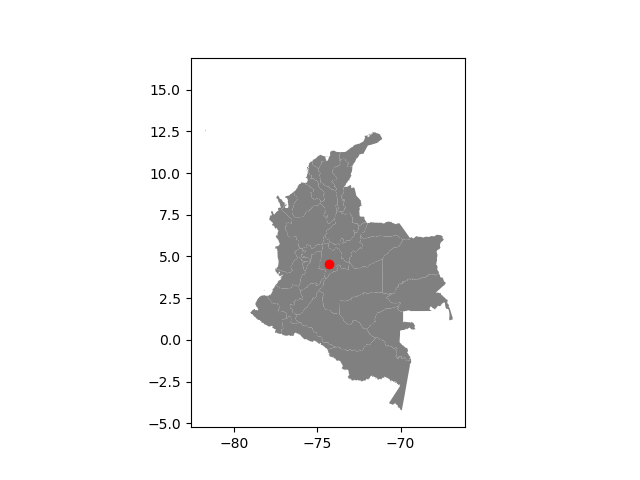

In [18]:
fig, ax = plt.subplots()
colombia.plot(ax=ax, facecolor='gray');
city_gdf.plot(ax=ax,color='red');
ax.set_aspect('equal')

![alrighty](https://media.giphy.com/media/5hc2bkC60heU/giphy.gif)

So we can see that the point for Bogota is in fact, within Colombia. How about we select the department it is within.

In [19]:
for index, row in colombia.iterrows():
    if city_gdf.within(row['geometry']).any():
        print(row['NAME_1_x'])

Cundinamarca


Interesante! So now we know the department which has the capital city and we didn't even have to use google.

We did the previous selection using a geospatial __location__ technique.

Since we know the name of the department, now we can use an __attribute__ selection.

In [20]:
cundinamarca = colombia.loc[colombia.NAME_1_x == "Cundinamarca"]

In [21]:
cundinamarca

,GID_0,NAME_0_x,GID_1,NAME_1_x,VARNAME_1_x,NL_NAME_1_x,TYPE_1_x,ENGTYPE_1_x,CC_1,HASC_1,geometry,asdf_id,lights,drug_count,drug_other,herb,coke,heroin,drug_mix,ucdp_deaths,CCN_1,NAME_0_y,Shape_Area,VARNAME_1_y,ENGTYPE_1_y,NAME_1_y,ID_0,CCA_1,ID_1,TYPE_1_y,Shape_Length,NL_NAME_1_y,ISO
13,COL,Colombia,COL.14_1,Cundinamarca,None,None,Departamento,Department,None,CO.CU,"POLYGON ((-73.13570 4.64760, -73.12880 4.64930...",13,180695.15625,19923,19923,0,0,0,0,0.0,NaN,Colombia,1.99299,NaN,Department,Cundinamarca,53,NaN,14,Departamento,8.582517,NaN,COL


Nice! We have now done selection by both location and attribute. Lets move on to buffers.

# Buffers

So if we notice, the district of Bogota has no deaths recorded in 2014 within the UCDP data.  But that does not neccisarily mean violence is not proximate to the capital.  How about we buffer the city by some kilometers and see what the other districts look like.

In [22]:
city_copy = city_gdf.copy()
city_copy['geometry'] = city_copy.geometry.buffer(2)

<IPython.core.display.Javascript object>


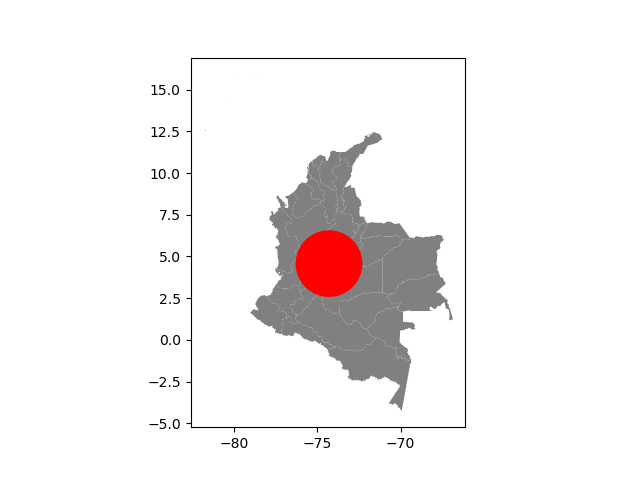

In [23]:
fig, ax = plt.subplots()
colombia.plot(ax=ax, facecolor='gray');
city_copy.plot(ax=ax,color='red');
ax.set_aspect('equal')

Now that we have the buffer, lets find all the departments which intersect with this point.

We use the "intersects" function.

In [24]:
for index, row in colombia.iterrows():
    if city_copy.intersects(row['geometry']).any():
        print("'" + str(row['NAME_1_x']) + "'")

'Antioquia'
'Boyacá'
'Caldas'
'Caquetá'
'Casanare'
'Chocó'
'Cundinamarca'
'Huila'
'Meta'
'Quindío'
'Risaralda'
'Santander'
'Tolima'
'Valle del Cauca'


In [25]:
depts= ['Antioquia','Boyacá', 'Caldas','Caquetá','Casanare',
        'Chocó','Cundinamarca','Huila','Meta','Quindío',
        'Risaralda','Santander','Tolima','Valle del Cauca'
       ]

Here we can select all these departments using the loc and isin functions.

In [26]:
depts_bogota = colombia.loc[colombia.NAME_1_x.isin(depts)]

In [27]:
depts_bogota

,GID_0,NAME_0_x,GID_1,NAME_1_x,VARNAME_1_x,NL_NAME_1_x,TYPE_1_x,ENGTYPE_1_x,CC_1,HASC_1,geometry,asdf_id,lights,drug_count,drug_other,herb,coke,heroin,drug_mix,ucdp_deaths,CCN_1,NAME_0_y,Shape_Area,VARNAME_1_y,ENGTYPE_1_y,NAME_1_y,ID_0,CCA_1,ID_1,TYPE_1_y,Shape_Length,NL_NAME_1_y,ISO
1,COL,Colombia,COL.2_1,Antioquia,None,None,Departamento,Department,None,CO.AN,"MULTIPOLYGON (((-76.99986 8.99986, -77.00014 8...",1,151073.993896,51678,43210,0,8465,3,0,17.0,NaN,Colombia,5.168365,NaN,Department,Antioquia,53,NaN,2,Departamento,19.141026,NaN,COL
5,COL,Colombia,COL.6_1,Boyacá,None,None,Departamento,Department,None,CO.BY,"POLYGON ((-74.21580 5.46130, -74.21810 5.46130...",5,64905.050781,19084,19084,0,0,0,0,0.0,NaN,Colombia,1.908535,NaN,Department,Boyacá,53,NaN,6,Departamento,12.360546,NaN,COL
6,COL,Colombia,COL.7_1,Caldas,None,None,Departamento,Department,None,CO.CL,"POLYGON ((-75.35690 4.89080, -75.35340 4.88500...",7,34850.699219,6157,2692,0,0,3465,0,0.0,NaN,Colombia,0.616329,NaN,Department,Caldas,53,NaN,8,Departamento,5.458548,NaN,COL
7,COL,Colombia,COL.8_1,Caquetá,None,None,Intendencia,Intendancy,None,CO.CQ,"POLYGON ((-73.88365 -0.43056, -73.88620 -0.428...",8,8410.000000,73269,45347,0,27879,41,2,5.0,NaN,Colombia,7.324507,NaN,Intendancy,Caquetá,53,NaN,9,Intendencia,17.014369,NaN,COL
8,COL,Colombia,COL.9_1,Casanare,None,None,Intendencia,Intendancy,None,CO.CS,"POLYGON ((-72.63630 4.28270, -72.64550 4.27870...",9,45913.351562,36404,36359,0,45,0,0,0.0,NaN,Colombia,3.640810,NaN,Intendancy,Casanare,53,NaN,10,Intendencia,9.940841,NaN,COL
11,COL,Colombia,COL.12_1,Chocó,None,None,Departamento,Department,None,CO.CH,"MULTIPOLYGON (((-77.38069 4.37347, -77.38069 4...",12,4946.160126,36953,36953,0,0,0,0,6.0,NaN,Colombia,3.694846,NaN,Department,Chocó,53,NaN,13,Departamento,23.394558,NaN,COL
13,COL,Colombia,COL.14_1,Cundinamarca,None,None,Departamento,Department,None,CO.CU,"POLYGON ((-73.13570 4.64760, -73.12880 4.64930...",13,180695.156250,19923,19923,0,0,0,0,0.0,NaN,Colombia,1.992990,NaN,Department,Cundinamarca,53,NaN,14,Departamento,8.582517,NaN,COL
16,COL,Colombia,COL.17_1,Huila,None,None,Departamento,Department,None,CO.HU,"POLYGON ((-76.13251 1.49347, -76.13480 1.49972...",16,52760.949219,16523,1776,0,405,13891,451,0.0,NaN,Colombia,1.650928,NaN,Department,Huila,53,NaN,17,Departamento,8.377296,NaN,COL
19,COL,Colombia,COL.20_1,Meta,None,None,Departamento,Department,None,CO.ME,"POLYGON ((-73.66020 1.61090, -73.68620 1.61270...",19,67754.566406,69408,28267,0,41137,4,0,25.0,NaN,Colombia,6.943740,NaN,Department,Meta,53,NaN,20,Departamento,15.156743,NaN,COL
23,COL,Colombia,COL.24_1,Quindío,None,None,Departamento,Department,None,CO.QD,"POLYGON ((-75.66320 4.24170, -75.67070 4.22550...",23,18367.949219,1410,0,0,0,1410,0,0.0,NaN,Colombia,0.141012,NaN,Department,Quindío,53,NaN,24,Departamento,1.876727,NaN,COL


In [28]:
depts_bogota[['drug_count', 'ucdp_deaths']].describe()

,drug_count,ucdp_deaths
count,14.000000,14.000000
mean,28274.642857,4.857143
std,22765.051834,7.724657
min,1410.000000,0.000000
25%,16869.250000,0.000000
50%,19503.500000,0.500000
75%,36815.750000,5.750000
max,73269.000000,25.000000


In [29]:
colombia[['drug_count', 'ucdp_deaths']].describe()

,drug_count,ucdp_deaths
count,32.000000,29.000000
mean,28964.187500,5.186207
std,23312.186682,7.921387
min,46.000000,0.000000
25%,17691.500000,0.000000
50%,20195.000000,0.000000
75%,38531.000000,7.000000
max,87353.000000,28.000000


Now we can make comparisons between these two groups of departments within Colombia regarding descriptive spatial statistics.

# Raster

On to the raster data.  This data is slightly different than the discrete vector data we have worked with thus far.  Today we will work on importing a single raster image, displaying it, and then clipping it using a mask.

In [32]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
%matplotlib inline
import pycrs
import json

Many of you(probably all) will have issues with the imports.

Use conda install package in the anaconda prompt,
or use the !pip install package in the box within jupyter.

Lets start with just loading the world map we have stored in our data folder. Since we changed to the subfolder of colombia, we will need to go backwards in the directory.  We can do this with the .. as you see below.

In [33]:
os.getcwd()

'/Users/PrideRock/Google Drive/github/POS4764/Labs/data/colombia'

In [34]:
world = gpd.read_file('../worldmap/cshapes.shp') 
colombia_full = world.loc[world.CNTRY_NAME == "Colombia"]

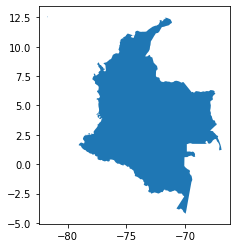

In [35]:
colombia_full.plot()

Ok now we use the rasterio (stands for raster input output) package and the function open, to get our raster image. These are .tif files.

In [36]:
raster1 = rasterio.open('noaa/avh_1.tif')

Just like that we have our first raster!

You can find a huge repository of free and open-source rasters here:

https://earthexplorer.usgs.gov/


Lets just show this image as is.

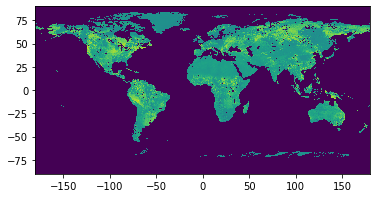

In [37]:
show(raster1)

Interesting, but can we change the color scheme?

Yes! Just like we did with the choropleth maps we can use the cmap choices.

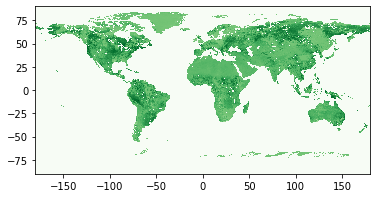

In [40]:
show(raster1, cmap='Greens')

![lit](https://media.giphy.com/media/jba8ucWVAhG9VcUkx9/giphy.gif)

Alright lets do something else, what if we don't want the entire raster but instead just a small portion.  Since the lab before we have focused on Colombia, lets go ahead and use that as our focus.

First step is we can define a function to get the geometry of the mask to then apply it.

In [41]:
def getmask(polygon):
    
    return [json.loads(polygon.to_json())['features'][0]['geometry']]

Now lets use the full shapefile of Colombia.

In [42]:
coords = getmask(colombia_full)

In [43]:
coords

[{'type': 'MultiPolygon',
  'coordinates': [[[[-74.86080890208149, 11.125491094180461],
     [-74.83459090205707, 11.105554094161889],
     [-74.50500890175013, 10.993327094057378],
     [-74.47611790172321, 10.987218094051684],
     [-74.45083590169968, 10.983891094048587],
     [-74.42361790167432, 10.983054094047802],
     [-74.37972690163345, 10.983054094047802],
     [-74.341672901598, 10.986664094051164],
     [-74.31598190157408, 10.991809094055952],
     [-74.29222690155196, 10.999027094062683],
     [-74.30487290156374, 10.983473094048193],
     [-74.32722690158455, 10.974864094040171],
     [-74.35473590161017, 10.971109094036677],
     [-74.41902690167005, 10.965827094031766],
     [-74.46529090171313, 10.971318094036874],
     [-74.5917459018309, 10.877636093949619],
     [-74.60750890184559, 10.823609093899307],
     [-74.59330890183236, 10.783300093861769],
     [-74.51918190176333, 10.81277309388922],
     [-74.46529090171313, 10.76597309384563],
     [-74.45778190170614

Now we can use the mask function we imported to actually get the images themseleves.

In [44]:
out_img, out_transform = mask(raster1, shapes=coords, crop=True)

In [45]:
out_meta = raster1.meta.copy()

In [49]:
out_img

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int16)

Now lets name the clipped raster file something, so we can actually write it into our folder.

In [48]:
out_tif = r"clipped_colombia.tif"

In [50]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

In [51]:
clipped = rasterio.open(out_tif)

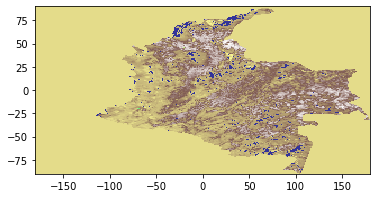

In [53]:
show(clipped, cmap='terrain')

Finally lets make our plot a little prettier!

Text(0.5, 1.0, 'Colombia NDVI Raster')

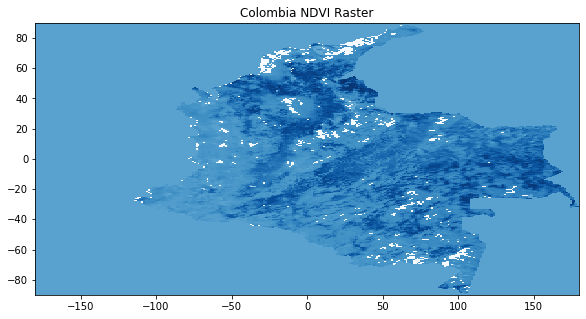

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
show(clipped, cmap='Blues', ax=ax)
plt.title("Colombia NDVI Raster")

### We did it!!

![excited](http://giphygifs.s3.amazonaws.com/media/nNxT5qXR02FOM/giphy.gif)